In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from sklearn.datasets import fetch_openml

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Access the data and target
X, y = mnist['data'], mnist['target']

# Display the shape of the data
print("Data shape:", X.shape)
print("Target shape:", y.shape)
print(type(mnist))


Data shape: (70000, 784)
Target shape: (70000,)
<class 'sklearn.utils._bunch.Bunch'>


In [9]:
import pandas as pd
X = pd.DataFrame(mnist['data'])
y = pd.Series(mnist['target'], name='target')

# Combine the features and target into a single DataFrame
mnist_df = pd.concat([X, y], axis=1)

# Display the first few rows of the DataFrame
print(mnist_df.head())

   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel776  pixel777  pixel778  pixel779  pixel780  pixel781  \
0        0  ...         0         0         0         0         0         0   
1        0  ...         0         0         0         0         0         0   
2        0  ...         0         0         0         0         0         0   
3        0  ...         0         0         0         0         0         0   
4        0  ...         0         0         0         0         0         0   

   pixel782  pixel783  pixel784  target  
0         0         

In [10]:
print(len(X.values[0]))

784


In [11]:
from skimage.feature import hog

def convolve2d(image, kernel):
    # Get the dimensions of the kernel
    kernel_height, kernel_width = kernel.shape
    # Calculate the padding size
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    
    # Pad the image to handle borders
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    
    # Get the dimensions of the padded image
    padded_height, padded_width = padded_image.shape
    
    # Create an output array
    output = np.zeros_like(image, dtype=np.float64)
    
    # Perform convolution
    for i in range(pad_height, padded_height - pad_height):
        for j in range(pad_width, padded_width - pad_width):
            # Extract the region of interest
            region = padded_image[i - pad_height:i + pad_height + 1, j - pad_width:j + pad_width + 1]
            # Apply the kernel
            output[i - pad_height, j - pad_width] = np.sum(region * kernel)
    
    return output

def apply_sobel_filters(image):
    # Sobel kernels
    sobel_x = np.array([[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]])

    sobel_y = np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]])

    # Apply Sobel filters
    gradient_x = convolve2d(image, sobel_x)
    gradient_y = convolve2d(image, sobel_y)

    return gradient_x, gradient_y

In [21]:
def apply_gaussian_filter(image, sigma=1.0):
    # Create a Gaussian kernel
    size = int(2 * np.ceil(2 * sigma) + 1)  # Kernel size
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    
    # Gaussian function
    gaussian_kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gaussian_kernel /= np.sum(gaussian_kernel)  # Normalize the kernel

    # Apply Gaussian filter
    smoothed_image = convolve2d(image, gaussian_kernel)

    return smoothed_image


In [12]:
# Load the image
features = []
for image in X.values:
    image = image.reshape(28, 28)

    # Apply Sobel filters
    gradient_x, gradient_y = apply_sobel_filters(image)
    
    G = np.sqrt(gradient_x**2 + gradient_y**2)
    
    fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(8, 8),
    cells_per_block=(1, 1),
    visualize=True,
    )
    
    features.append(np.concatenate((G.flatten(), fd)))
    
    
np.save('features.npy',features)

KeyboardInterrupt: 

In [13]:
features = np.load('features.npy')

In [14]:
X_minus_mean = X - X.mean()
features_minus_mean = features - np.mean(features)

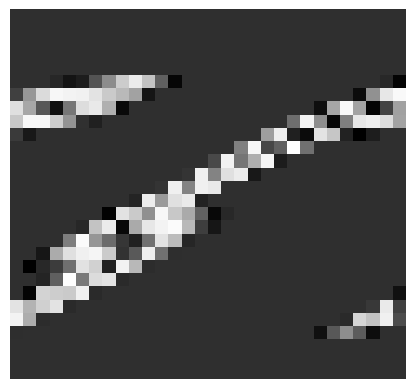

In [15]:
# Truncate to 840 elements
truncated_features = features_minus_mean[100][:840]

# Reshape to (28, 30)
reshaped_features = truncated_features.reshape(28, 30)

# Visualize
plt.imshow(abs(reshaped_features), cmap='gray')
plt.axis('off')
plt.show()


In [16]:
features_minus_mean

array([[-168.18035024, -168.18035024, -168.18035024, ..., -167.77584488,
        -167.88928854, -167.77138648],
       [-168.18035024, -168.18035024, -168.18035024, ..., -168.18035024,
        -168.13375847, -168.11946755],
       [-168.18035024, -168.18035024, -168.18035024, ..., -168.18035024,
        -168.18035024, -167.58176627],
       ...,
       [-168.18035024, -168.18035024, -168.18035024, ..., -168.18035024,
        -168.18035024, -168.18035024],
       [-168.18035024, -168.18035024, -168.18035024, ..., -168.18035024,
        -167.68487639, -167.80960922],
       [-168.18035024, -168.18035024, -168.18035024, ..., -168.13489996,
        -168.18035024, -168.18035024]])

150


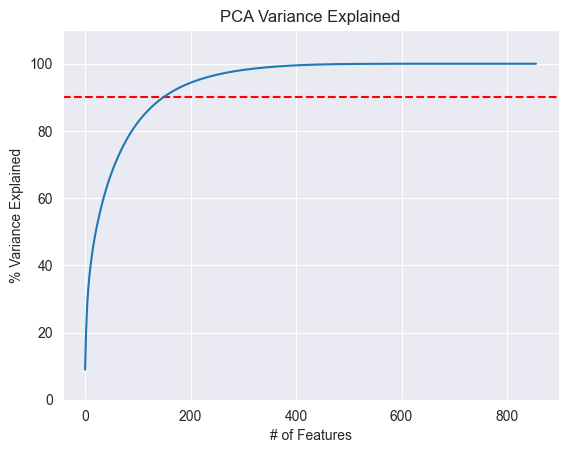

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'features' is your original dataset
pca = PCA()
pca.fit(features_minus_mean)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio) * 100
n_component = np.argmax(cumulative_variance >= 90) + 1
print(n_component)
# Plotting
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Variance Explained')
plt.ylim(0, 110)
plt.axhline(y=90, color='r', linestyle='--')
plt.plot(cumulative_variance)
plt.show()


In [20]:
X_reduced = (PCA(n_components=n_component)).fit_transform(features_minus_mean)
print(X_reduced.shape)

(70000, 150)


### phase 3

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Load the Iris dataset
data = pd.read_csv('raw_reduced.csv')
X = data.iloc[:, :-1].values  # All columns except the last
y = data.iloc[:, -1].values  # labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Create a hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy (CV):", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
Best Accuracy (CV): 0.8143571428571429
Test Accuracy: 0.8220714285714286


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Load the Iris dataset
data = pd.read_csv('mnist_sobel.csv')
X = data.iloc[:, :-1].values  # All columns except the last
y = data.iloc[:, -1].values  # labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Create a hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy (CV):", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Best Accuracy (CV): 0.8294642857142858
Test Accuracy: 0.8352142857142857


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Step 1: Load the MNIST dataset from CSV
# Replace 'mnist.csv' with the path to your MNIST CSV file
mnist_data = pd.read_csv('raw_reduced.csv')

# Step 2: Separate features and labels
X = mnist_data.iloc[:, :-1].values  # All columns except the last
y = mnist_data.iloc[:, -1].values  # labels

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create an SVM classifier
model = SVC(kernel='linear')  # You can also try 'rbf', 'poly', etc.

# Step 5: Train the model
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Visualize some predictions
def plot_digits(images, labels, predictions, n=10):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {labels[i]}\nPred: {predictions[i]}')
        plt.axis('off')
    plt.show()

# Visualize the first 10 test images and their predictions
plot_digits(X_test, y_test, y_pred, n=10)
